In [3]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df = pd.read_csv(r'C:\Users\mtsil\Desktop\english_essays.csv')
df.head(2)

,student_nr,class_nr,school_nr,canton_nr,rater,i1_1,i1_2,i1_3,i1_4,sr1_1,sr1_2,sr1_3,sr1_4,wle_esch,sewle_esch,punkte_esch,essay,sumscore
0,1,1_3_5,1_3,1,7,2,2,2,1,2,2,2,2,-0.178414,0.483534,810,How to boost your energy Before you go to slee...,15
1,2,1_3_5,1_3,1,7,2,2,2,2,2,2,2,2,0.063664,0.492626,824,"Student life All students must go to school, g...",16


In [4]:
from num2words import num2words

# convert numbers to words

def clean_text(text):
    text = " ".join([num2words(word) if word.isdigit() else word for word in text.split()])
    return text

df['essay']= df["essay"].apply(clean_text)

In [5]:
# remove those digits which could not be converted into words

def clean(text):
    text= ''.join(c for c in text if not c.isdigit())
    
   
    return text



df['essay']= df["essay"].apply(clean)

In [6]:
import contractions

# expand contractions

df['essay']= df['essay'].apply(lambda x: contractions.fix(x))

In [7]:
# convert to lower cases

df['essay'] = df['essay'].str.lower()

In [8]:
# remove punctuation marks apart from full stop
# remove special characters
# remove whitespaces

import re


def clean(text):
    
    text = re.sub(r'[^a-zA-Z0-9\s\.]', '', text) 
   
    text = " ".join(text.split())
    
    
    return text



df['essay']= df["essay"].apply(clean)

In [9]:
# remove a list of specific words

remove_words = ['hundred', 'thousand', 'h','wichtig', 'vor', 'oder', 'notiz', 'gesundheit', 'z.b.', 'bevor', 'trotzdem',
'sportler', 'habe', 'wenn', 'trinke', 'ungesund',  'gesund', 'obst', 'bewegen', 'ca', 'musst']


df['essay'] = df['essay'].apply(lambda x: ' '.join([word for word in x.split() if word not in (remove_words)]))

In [10]:
df['essay'] = df['essay'].str.replace('how to boost your energy', '')

In [11]:
# create df1 to store the essay and i1_4 variables

df1 = df[['essay', 'i1_4']]

In [12]:
# check the distribution of the values for the cohesion criterion

df1[['i1_4']].value_counts()

i1_4
2       54
1       39
3        6
0        1
Name: count, dtype: int64

In [13]:
from sklearn.preprocessing import KBinsDiscretizer
# Quantile Discretization (convert the continuous values of the target variable into discrete categories)

quantile_discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')
df1['i1_4'] = quantile_discretizer.fit_transform(df1[['i1_4']])

df1.head(2)

C:\Users\mtsil\AppData\Local\Temp\ipykernel_19616\1648634502.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['i1_4'] = quantile_discretizer.fit_transform(df1[['i1_4']])


,essay,i1_4
0,before you go to sleep do not go on the mobil...,0.0
1,student life all students must go to school go...,1.0


In [15]:
df1['i1_4'] = df1['i1_4'].astype(int)
df1.head(2)

C:\Users\mtsil\AppData\Local\Temp\ipykernel_19616\3000449119.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['i1_4'] = df1['i1_4'].astype(int)


,essay,i1_4
0,before you go to sleep do not go on the mobil...,0
1,student life all students must go to school go...,1


In [16]:
df1['i1_4'].value_counts(ascending = True)

i1_4
0    40
1    60
Name: count, dtype: int64

In [17]:
X = df1['essay']
y = df1['i1_4']

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
td = TfidfVectorizer(max_features = 6000)
X = td.fit_transform(X).toarray()

In [20]:
# no need for the parameter test_size becauseone-third of the data it is set aside as test data, known as the out-of-bag (oob) sample 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                     random_state=0, 
                                                    shuffle=True)

In [21]:
import numpy as np

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))

In [38]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 150, class_weight= class_weights, max_features = 'log2', min_samples_split = 8, min_samples_leaf = 10, random_state=42, n_jobs=-1)
model.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1.1029411764705883,
                                     1: 0.9146341463414634},
                       max_features='log2', min_samples_leaf=10,
                       min_samples_split=8, n_estimators=150, n_jobs=-1,
                       random_state=42)

In [39]:
predictions = model.predict(X_test)

In [24]:
from sklearn.metrics import accuracy_score

In [40]:
print(f'Training set accuracy: {model.score(X_train, y_train):.4f}')
print(f'Test set accuracy: {model.score(X_test, y_test):.4f}')

Training set accuracy: 0.8533
Test set accuracy: 0.6800


In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.38      0.50      0.43         6
           1       0.82      0.74      0.78        19

    accuracy                           0.68        25
   macro avg       0.60      0.62      0.60        25
weighted avg       0.72      0.68      0.69        25



In [42]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test,predictions)

<Axes: >

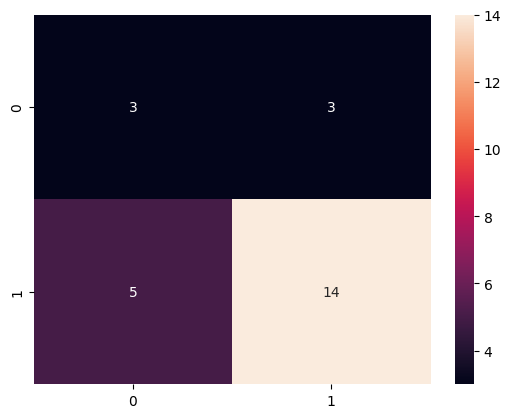

In [43]:
import seaborn as sn
sn.heatmap(cm,annot=True,fmt='.2g')

In [44]:
from sklearn.metrics import roc_auc_score

y_pred = model.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_pred)

0.5964912280701754

In [45]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y_test, predictions)

0.21259842519685046

In [46]:
import joblib 


filename = 'joblib_model3_cohesion_english_essays.sav'
joblib.dump(model, filename)

['joblib_model3_cohesion_english_essays.sav']

In [47]:
loaded_model = joblib.load(filename)
loaded_model

RandomForestClassifier(class_weight={0: 1.1029411764705883,
                                     1: 0.9146341463414634},
                       max_features='log2', min_samples_leaf=10,
                       min_samples_split=8, n_estimators=150, n_jobs=-1,
                       random_state=42)

In [48]:
y_predict = model.predict(X_test)

In [49]:
print(classification_report(y_test, y_predict)) 

              precision    recall  f1-score   support

           0       0.38      0.50      0.43         6
           1       0.82      0.74      0.78        19

    accuracy                           0.68        25
   macro avg       0.60      0.62      0.60        25
weighted avg       0.72      0.68      0.69        25

